# Boston Housing Price - Regression

In [1]:
from tensorflow.keras.datasets import boston_housing

In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


## Scale the data

We should scale the date because it is represented in different ranges, for example, some instances have its crime_rate going from 0 to 12 and others going from 0 to 1.

In [3]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [7]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential([
        layers.Dense(64, activation="relu", input_shape=(train_data.shape[1], )),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

## Validate the model using k-fold

In general, applying k-fold cross validation when there is no much data is a good solution

In [10]:
import numpy as np

k = 4
num_val_samples = train_data.shape[0] // 4
num_epochs = 50
all_scores = []

for i in range(k):
    print("Processing fold #", i + 1)
    val_data = train_data[i * num_val_samples:(i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples:(i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0
    )
     
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0
    )
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, 
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1,
                        verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)


Processing fold # 1
Processing fold # 2
Processing fold # 3
Processing fold # 4


In [11]:
all_scores

[2.0534264380388922, 2.515882104930311, 2.7234522175080706, 2.3506325648562743]

In [12]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print("Processing fold #", i + 1)
    val_data = train_data[i * num_val_samples:(i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples:(i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0
    )
     
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0
    )
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, 
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1,
                        verbose=0)

    all_mae_histories.append(history.history["val_mean_absolute_error"])


Processing fold # 1
Processing fold # 2
Processing fold # 3
Processing fold # 4


In [14]:
average_mae_history = [
    np.mean([ x[i] for x in all_mae_histories ]) for i in range(num_epochs)
]

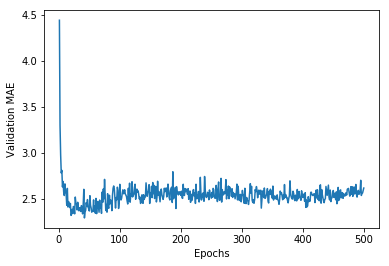

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline  

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel('Validation MAE')
plt.show()

Apply a moving average to obtain an smooth curve

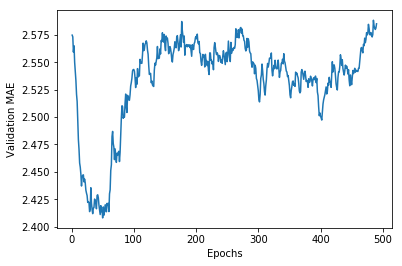

In [18]:
def smooth_curve(points, factor=.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:]) # Remove 10 first points because they have a large scale

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel("Epochs")
plt.ylabel('Validation MAE')
plt.show()

Over 60 epochs model overfits the train data

In [22]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)

In [23]:
test_mse_score, test_mae = model.evaluate(test_data, test_targets)
test_mae

102/102 [==============================] - 0s 1ms/step


2.588144293018416